<a href="https://colab.research.google.com/github/Kamal-Chandra/Image-Recognition/blob/main/Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
Implementing Siamese Neural Networks for One-shot Image Recognition

[Research Paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

**Model**

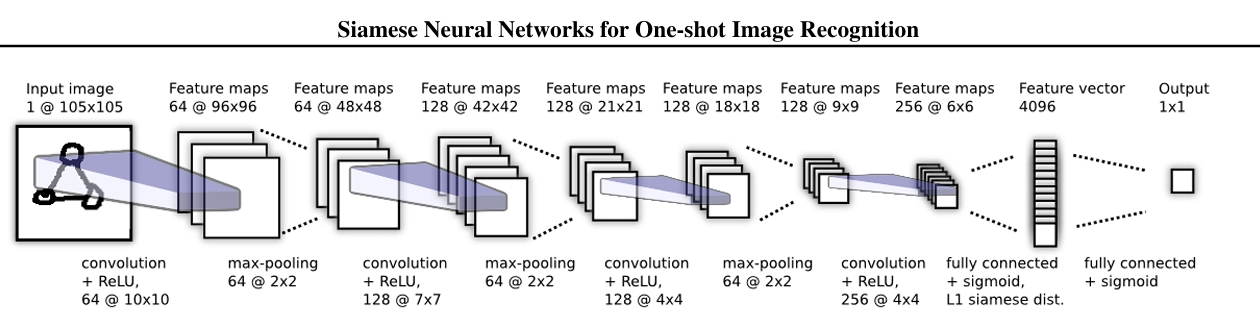

[Dataset used for negative examples](http://vis-www.cs.umass.edu/lfw/lfw.tgz)

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

# **Data Collection**

In [3]:
POS_PATH = os.path.join('/content/data', 'positive')
NEG_PATH = os.path.join('/content/data', 'negative')
ANC_PATH = os.path.join('/content/data', 'anchor')

os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [4]:
import urllib.request
import tarfile
import shutil

url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
download_path = '/content/data/lfw.tgz'
extract_path = '/content/data'

urllib.request.urlretrieve(url, download_path)

with tarfile.open(download_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

os.remove(download_path)

extract_path = os.path.join(extract_path, 'lfw')

for directory in os.listdir(extract_path) :
  subdir = os.path.join(extract_path, directory)
  for file in os.listdir(subdir) :
    EX_PATH = os.path.join(extract_path, directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

shutil.rmtree(extract_path)

In [5]:
import cv2
import uuid

cap = cv2.VideoCapture(0)

while cap.isOpened():
  ret, frame = cap.read()

  frame = frame[120: 120+250, 200:200+250, :]

  if cv2.waitKey(1) & 0XFF == ord('a'):
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid4()))
    cv2.imwrite(imgname, frame)

  if cv2.waitKey(1) & 0XFF == ord('p'):
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid4()))
    cv2.imwrite(imgname, frame)

  cv2.imshow('Image Collection', frame)

  if cv2.waitKey(1) & 0XFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

# **Data Processing**

In [6]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img, (100,100))
  img = img/255.0
  return img

def preprocess_twin(input_img, validation_img, label):
  return (preprocess(input_img), preprocess(validation_img), label)

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/'+'*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/'+'*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/'+'*.jpg').take(300)

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
# Dataloader Pipleline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [9]:
# Training Partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing Partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# **Modelling**

In [10]:
# Embedding Layer
def make_embedding():
  inp = Input(shape=(100,100,3), name='input_image')

  # First Block
  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  # Second Block
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  # Third Block
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  # Final Embedding Layer
  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp] , outputs=[d1] , name= 'embedding')

embedding = make_embedding()

In [11]:
# Distance Layer (Custom Neural Network Layer)
class L1Dist(Layer):
  def _init_(self, **kwargs):
    super().__init__()

  # Similarity Comparision
  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [12]:
def make_siamese_model():
  input_image = Input(name='input_img', shape= (100,100,3))
  validation_image = Input(name='validation_img', shape= (100,100,3))

  # Combine Siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # Classification Layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()

# **Training**

In [13]:
# Loss Function
binary_cross_loss = tf.losses.BinaryCrossentropy()

# Optimizer
opt = tf.keras.optimizers.Adam(1e-4)

# Establish Checkpoints
checkpoint_dir = '/content/data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [14]:
@tf.function
def train_step(batch):
  with tf.GradientTape() as tape:
    X = batch[:2]
    y = batch[2]
    yhat = siamese_model(X, training=True)
    loss = binary_cross_loss(y, yhat)

  grad = tape.gradient(loss, siamese_model.trainable_variables)

  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  return loss

In [15]:
def train(data, EPOCHS):
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch{}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    for idx, batch in enumerate(data):
      loss = train_step(batch)
      progbar.update(idx+1)

    if epoch%10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [16]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch1/50
27/27 [==============================] - 43s 2s/step

 Epoch2/50
27/27 [==============================] - 41s 2s/step

 Epoch3/50
27/27 [==============================] - 40s 1s/step

 Epoch4/50
27/27 [==============================] - 40s 1s/step

 Epoch5/50
27/27 [==============================] - 40s 1s/step

 Epoch6/50
27/27 [==============================] - 39s 1s/step

 Epoch7/50
27/27 [==============================] - 39s 1s/step

 Epoch8/50
27/27 [==============================] - 40s 1s/step

 Epoch9/50
27/27 [==============================] - 40s 1s/step

 Epoch10/50
27/27 [==============================] - 40s 1s/step

 Epoch11/50
27/27 [==============================] - 40s 1s/step

 Epoch12/50
27/27 [==============================] - 41s 2s/step

 Epoch13/50
27/27 [==============================] - 39s 1s/step

 Epoch14/50
27/27 [==============================] - 39s 1s/step

 Epoch15/50
27/27 [==============================] - 40s 1s/step

 Epoch16/50
27/27 

# **Evaluation**

In [24]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

m_accuracy = Accuracy()
m_recall = Recall()
m_precision = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    y_hat = siamese_model.predict([test_input, test_val])

    m_accuracy.update_state(y_true, y_hat)
    m_recall.update_state(y_true, y_hat)
    m_precision.update_state(y_true, y_hat)

accuracy_result = m_accuracy.result().numpy()
recall_result = m_recall.result().numpy()
precision_result = m_precision.result().numpy()

print("Accuracy:", accuracy_result)
print("Recall:", recall_result)
print("Precision:", precision_result)

1/1 [==============================] - 0s 131ms/step
Accuracy: 0.75
Recall: 1.0
Precision: 1.0


In [21]:
# Save Model
siamese_model.save('siameseModel.h5')
siamese_model.save('siameseModel.keras')